# Project 2 - Deep Q-Learning

### Install necessary libraries and import packages


In [1]:
!wget https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip
!unzip -q frogger.zip


--2021-02-27 18:41:16--  https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip
Resolving sites.google.com (sites.google.com)... 172.217.203.138, 172.217.203.139, 172.217.203.102, ...
Connecting to sites.google.com (sites.google.com)|172.217.203.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip?attredirects=0 [following]
--2021-02-27 18:41:16--  https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip?attredirects=0
Reusing existing connection to sites.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://1b8e3dd4-a-1e6e9713-s-sites.googlegroups.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip?attachauth=ANoY7co2Gw1aldnX36zFf6YUJvLghogo2yASiLTdk32XQvyBPFfVj-92gMlJRarYo7SwxT9S4t6XUct7V-4Lyxc0Zn_RHagWfYDO6rLKkln-7fkHpa4t_mzJlVh2TYnr3T8u5uubb6Xmt6ItpTHJOS4edxht-Iim0wF2RK6XtLW

In [2]:
!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl 
!pip -q install gym pyvirtualdisplay pygame


# Environment
import gym # OpenAI gym 
import frogger_env
#import pygame
gym.logger.set_level(40) # suppress warnings on gym

# Models and computation
import torch # will use pyTorch to handle NN 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque
import random
from random import sample

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

# IO
from pathlib import Path
import os 


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa

Let's define a simple helper function for visualization of episodes


In [24]:
display = Display(visible=0, size=(600, 400))
display.start()

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Lets test things out!

In [4]:
env = gym.make("frogger-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = 1#env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video('./video')

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>



The observation that the agent receives is a history of lidar scans + distance to the goal.

The action space consists of three actions 0: stand still, 1: move up, 2: move down

In [5]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)
env.reset()
print(env.observation_space.shape[0])

observation space: Box(0.0, 1.0, (61,), float32)
action space: Discrete(3)
61


### Some useful functions

In [6]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space 
        
    Parameters
    ----------
    model: your Q network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1: 
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}" 
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine 
        
    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)

  

### Q1. Your DQN code

Implement below DQN to solve the frogger environment and enable the agent to reach the other side of the highway. 

Please, refer to the project descriprtion for more details. 

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import namedtuple

######################## Your code ####################################
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
# class for replay memory
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# class for QNetwork
class QNetwork(nn.Module): 
    def __init__(self, s_size,  a_size, fc1_units=32, fc2_units=32):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(s_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, a_size)

    def forward(self, state):
        """Perform forward propagation."""

        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x 


In [14]:
class DQNAgent():
    def __init__(self, state_size, action_size, batch_size, epochs, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.experiences_position = 0
        # Q-Network (this could also be passed in the initialization)
        self.qnetwork = QNetwork(state_size, action_size, 512, 128).to(device)
        # Optimizer (this could also be passed in the initialization)
        self.optimizer = optim.RMSprop(self.qnetwork.parameters(), lr=self.lr)

    def epsilon_greedy_action(self, state, eps):
        
        with torch.no_grad():
            q_values = self.qnetwork(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > eps:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))
        return action

    def greedy_action(self, state):
        with torch.no_grad():
            q_values = self.qnetwork(state).cpu().detach().data.numpy().squeeze()
        return np.argmax(q_values)

    def load_checkpoint(self, model_name):
        self.qnetwork.load_state_dict(torch.load(model_name))

    def evaluate(self, env, n_rollouts=1):
        rewards = []
        for _ in range(n_rollouts):
            state, done = env.reset(), False
            rewards.append(0)
            while not done:
                action = self.greedy_action(state)
                state, reward, done, _ = env.step(action)
                rewards[-1] += reward
        return np.mean(rewards), np.std(rewards)

    def collect_experience(self, env, state, eps):
        action = self.epsilon_greedy_action(state, eps)
        new_state, reward, is_terminal, info = env.step(action)
        # is_truncated = 'TimeLimit.truncated' in info
        experience = (state, action, reward, new_state, float(is_terminal)) 

        if len(self.experiences) < self.replay_capacity:
            self.experiences.append(None)
        self.experiences[self.experiences_position] = experience
        self.experiences_position = (self.experiences_position + 1) % self.replay_capacity

        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        return new_state, is_terminal

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        # batch_size = len(dones)
        q_predicted = self.qnetwork(states).gather(1, actions)
        q_next_states = target_net.qnetwork(next_states).detach()
        q_targets = q_next_states.max(1)[0].unsqueeze(1)
        q_target = rewards + (self.gamma*q_targets*(1-dones))

        loss = F.mse_loss(q_predicted, q_target)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train(self, env, seed, gamma, max_episodes, target_update, replay_capacity):
        self.seed = seed
        self.gamma = gamma
        self.replay_capacity = replay_capacity
        torch.manual_seed =(self.seed)
        np.random.seed(self.seed)

        self.episode_reward = []
        self.evaluation_scores = []
        self.experiences = []
        self.episode_timestep = []
        total_steps = 0
        result = np.empty((max_episodes, 3))
        result[:] = np.nan
        eps = 1
        for episode in range(1, max_episodes+1):
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)

            for step in range(max_steps_per_episode):
            # while True:
                state, is_terminal = self.collect_experience(env, state, eps)
                
                if len(self.experiences) >= self.batch_size:
                    experiences = np.array(random.sample(self.experiences, self.batch_size), dtype=object)

                    batches = [np.vstack(e) for e in experiences.T]
                    states, actions, rewards, new_states, is_terminals = batches
                    
                    # load the dataset to the device
                    states = torch.from_numpy(states).float().to(device)
                    actions = torch.from_numpy(actions).long().to(device)
                    new_states = torch.from_numpy(new_states).float().to(device)
                    rewards = torch.from_numpy(rewards).float().to(device)
                    is_terminals = torch.from_numpy(is_terminals).float().to(device)
                    experiences = (states, actions, rewards, new_states, is_terminals) 

                    self.learn(experiences)
                
                total_steps += 1
                if total_steps % target_update == 0:
                    target_net.qnetwork.load_state_dict(self.qnetwork.state_dict())

                
                if ((total_steps % 75) == 0) and (eps > 0.05):  # Epsilon decay
                    eps -= 0.005 # max samples

                if is_terminal:
                    break
            # if episode < (max_episodes*epsilon_saturation_factor):
            #     eps = 1 - ((eps_start-eps_end)/max_episodes)*episode

            # bookkeeping
            # done = True
            evaluation_score, _ = self.evaluate(env)


            self.evaluation_scores.append(evaluation_score)

            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_steps, mean_100_reward, mean_100_eval_score

 

            print('Episode: {:d}, Total Steps: {:d}, Train_reward: {:.2f}, Eval_reward: {:.2f}, Epsilon: {:.4f}'.format(episode-1,total_steps,\
            mean_100_reward, mean_100_eval_score, eps))

            
        print('*****************Training Complete************************')
        save_checkpoint(policy_net.qnetwork, 'model.pth')
        print('********************Model Saved************************')
        # export_to_local_drive('model.pth')
        env.close()
        # show_video('./video')
        return result

    def learn_ddqn(self, experiences, n_steps):      # n-step target
        states, actions, rewards, next_states, dones = experiences
        # batch_size = len(dones)
        # print(states.shape)
        q_predicted = self.qnetwork(states).gather(1, actions)
        q_target = rewards
        for k in range(n_steps):
            next_action = self.qnetwork(next_states).max(1)[1].unsqueeze(1) #.numpy()
            # print('target values', target_net.qnetwork(next_states))
            q_next_states = target_net.qnetwork(next_states).gather(-1, next_action)
            q_target += self.gamma**(k+1)*q_next_states
            # state_matrix = []
            # for act in next_action:
            #     state, _, _, _ = env.step(act.item())
            #     state_matrix.append(state)
            # # print('rewards', rewards)
            # next_states = torch.tensor(state_matrix).float().to(device)
        #     print(q_target)
        # print('\n')
        # print('qtarget',q_target)
        # print(q_target)
        # print('\n')
        loss = F.mse_loss(q_predicted, q_target)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        # for param in policy_net.parameters():
        #     param.grad.data.clamp_(-1, 1)
        self.optimizer.step()


    def train_ddqn(self, env, seed, gamma, max_episodes, target_update, replay_capacity, n_steps):
        # self.seed = seed
        self.gamma = gamma
        self.replay_capacity = replay_capacity
        self.n_step = n_steps
        # torch.manual_seed =(self.seed)
        # np.random.seed(self.seed)

        self.episode_reward = []
        self.evaluation_scores = []
        self.experiences = []
        self.episode_timestep = []
        total_steps = 0
        result = np.empty((max_episodes, 3))
        result[:] = np.nan
        eps = 1
        for episode in range(1, max_episodes+1):
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)

            # for step in range(max_steps_per_episode):
            while True:
                state, is_terminal = self.collect_experience(env, state, eps)
                
                if len(self.experiences) >= self.batch_size:
                    experiences = np.array(random.sample(self.experiences, self.batch_size), dtype=object)

                    batches = [np.vstack(e) for e in experiences.T]
                    states, actions, rewards, new_states, is_terminals = batches
                    # load the dataset to the device
                    states = torch.from_numpy(states).float().to(device)
                    actions = torch.from_numpy(actions).long().to(device)
                    new_states = torch.from_numpy(new_states).float().to(device)
                    rewards = torch.from_numpy(rewards).float().to(device)
                    is_terminals = torch.from_numpy(is_terminals).float().to(device)
                    experiences = (states, actions, rewards, new_states, is_terminals) 

                    self.learn_ddqn(experiences, self.n_step)
                
                total_steps += 1
                
                if total_steps % target_update == 0:
                    target_net.qnetwork.load_state_dict(self.qnetwork.state_dict())

                if ((total_steps % 75) == 0) and (eps > 0.05):  # Epsilon decay
                    eps -= 0.005 # max samples

                if is_terminal:
                    break

            # bookkeeping
            # done = True
            evaluation_score, _ = self.evaluate(env)

            # total_steps = int(np.sum(self.episode_timestep)) # total number of environment steps
            self.evaluation_scores.append(evaluation_score)

            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_steps, mean_100_reward, mean_100_eval_score



            print('Episode: {:d}, Total Steps: {:d}, Train_reward: {:.2f}, Eval_reward: {:.2f}, Epsilon: {:.4f}'.format(episode-1,total_steps,\
            mean_100_reward, mean_100_eval_score, eps))

            
        print('*****************Training Complete************************')
        save_checkpoint(policy_net.qnetwork, 'model.pth')
        print('********************Model Saved************************')
        # export_to_local_drive('model.pth')
        env.close()
        # show_video('./video')
        return result


In [15]:
env = gym.make("frogger-v0")
batch_size = 128
epochs = 40
lr = 5e-4
gamma = 0.999
seed = 12 # you could use multiple seeds and train multiple agents, keeping the best one
env.seed(seed)
max_steps = 40000
max_episodes = 1000
max_steps_per_episode = 1000
eps_start = 1.0
eps_end = 0.05

# eps_decay_rate = 200
epsilon_saturation_factor = 0.9
target_update = 500

replay_capacity = 15000
# replay_memory = ReplayMemory(replay_capacity)       # Initalize replay memory

policy_net = DQNAgent(env.observation_space.shape[0], env.action_space.n, batch_size, epochs, lr)
target_net = DQNAgent(env.observation_space.shape[0], env.action_space.n, batch_size, epochs, lr)
target_net.qnetwork.load_state_dict(policy_net.qnetwork.state_dict())

result = policy_net.train(env, seed, gamma, max_episodes, target_update, replay_capacity)
env.close()

del env





Episode: 0, Total Steps: 4, Train_reward: -0.01, Eval_reward: -0.01, Epsilon: 1.0000
Episode: 1, Total Steps: 10, Train_reward: -0.25, Eval_reward: -0.01, Epsilon: 1.0000
Episode: 2, Total Steps: 40, Train_reward: -0.17, Eval_reward: -0.01, Epsilon: 1.0000
Episode: 3, Total Steps: 63, Train_reward: -0.13, Eval_reward: -0.01, Epsilon: 1.0000
Episode: 4, Total Steps: 76, Train_reward: -0.20, Eval_reward: -0.01, Epsilon: 0.9950
Episode: 5, Total Steps: 87, Train_reward: -0.25, Eval_reward: -0.01, Epsilon: 0.9950
Episode: 6, Total Steps: 100, Train_reward: -0.22, Eval_reward: -0.01, Epsilon: 0.9950
Episode: 7, Total Steps: 109, Train_reward: -0.25, Eval_reward: -0.01, Epsilon: 0.9950
Episode: 8, Total Steps: 124, Train_reward: -0.28, Eval_reward: -0.02, Epsilon: 0.9950
Episode: 9, Total Steps: 128, Train_reward: -0.25, Eval_reward: -0.01, Epsilon: 0.9950
Episode: 10, Total Steps: 140, Train_reward: -0.27, Eval_reward: -0.01, Epsilon: 0.9950
Episode: 11, Total Steps: 156, Train_reward: -0.2

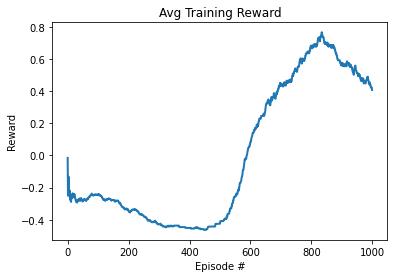

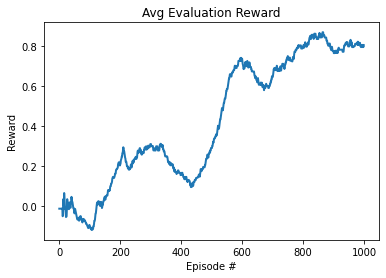

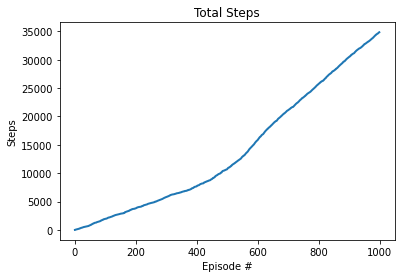

In [16]:
dqn_steps, dqn_rewards, dqn_score = result.T

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot(dqn_rewards, linewidth=2)
plt.ylabel('Reward')
plt.xlabel('Episode #')
ax1.set_title('Avg Training Reward')


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(dqn_score, linewidth=2)
plt.ylabel('Reward')
plt.xlabel('Episode #')
ax2.set_title('Avg Evaluation Reward')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
plt.plot(dqn_steps, linewidth=2)
plt.ylabel('Steps')
plt.xlabel('Episode #')
ax3.set_title('Total Steps')


plt.show()

In [17]:
env = gym.make('frogger-v0')
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
batch_size = 128
epochs = 40
lr = 5e-4
policy_net = DQNAgent(env.observation_space.shape[0], env.action_space.n, batch_size, epochs, lr)
policy_net.load_checkpoint('model.pth')
state = env.reset()
done = False
while not done:
    action = policy_net.greedy_action(state)
    state, reward, done, _ = env.step(action)
env.close()
show_video('./video')

del env

error: ignored

### Q2. Extend your DQN!

Here you will extend your DQN code to work on a variant of the frogger scenario, where the agent needs to reach a specified goal position while being able to move both horizontally and vertically and facing bidirectional traffic. 

You should extend your code by implementing any of the extensions discussed in class, or any other technique that you see fit. *An interesting extension could be to initialize your replay buffer with experiences collected by manually playing the game*! Ideally your modified DQN will lead to more stable and/or faster learning. Please see the website for details.  

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

######################## Your code ####################################

env = gym.make("frogger-v1")
batch_size = 128
epochs = 40
lr = 5e-4
gamma = 0.999
seed = 10 # you could use multiple seeds and train multiple agents, keeping the best one
env.seed(seed)
# max_steps = 45000
max_episodes = 1000
max_steps_per_episode = 1000
eps_start = 1.0
eps_end = 0.05

# eps_decay_rate = 200
epsilon_saturation_factor = 0.85
target_update = 1000
n_steps = 1
replay_capacity = 15000
# replay_memory = ReplayMemory(replay_capacity)       # Initalize replay memory

policy_net = DQNAgent(env.observation_space.shape[0], env.action_space.n, batch_size, epochs, lr)
target_net = DQNAgent(env.observation_space.shape[0], env.action_space.n, batch_size, epochs, lr)
target_net.qnetwork.load_state_dict(policy_net.qnetwork.state_dict())

result = policy_net.train_ddqn(env, seed, gamma, max_episodes, target_update, replay_capacity, n_steps)
env.close()

del env


Episode: 0, Total Steps: 27, Train_reward: -0.30, Eval_reward: -0.08, Epsilon: 1.0000
Episode: 1, Total Steps: 57, Train_reward: -0.29, Eval_reward: -0.07, Epsilon: 1.0000
Episode: 2, Total Steps: 99, Train_reward: -0.28, Eval_reward: -0.08, Epsilon: 0.9950
Episode: 3, Total Steps: 131, Train_reward: -0.28, Eval_reward: -0.06, Epsilon: 0.9950
Episode: 4, Total Steps: 153, Train_reward: -0.24, Eval_reward: -0.10, Epsilon: 0.9900
Episode: 5, Total Steps: 157, Train_reward: -0.20, Eval_reward: -0.13, Epsilon: 0.9900
Episode: 6, Total Steps: 180, Train_reward: -0.18, Eval_reward: -0.15, Epsilon: 0.9900
Episode: 7, Total Steps: 223, Train_reward: -0.19, Eval_reward: -0.17, Epsilon: 0.9900
Episode: 8, Total Steps: 290, Train_reward: -0.17, Eval_reward: -0.14, Epsilon: 0.9850
Episode: 9, Total Steps: 325, Train_reward: -0.18, Eval_reward: -0.16, Epsilon: 0.9800
Episode: 10, Total Steps: 339, Train_reward: -0.17, Eval_reward: -0.16, Epsilon: 0.9800
Episode: 11, Total Steps: 351, Train_reward: 

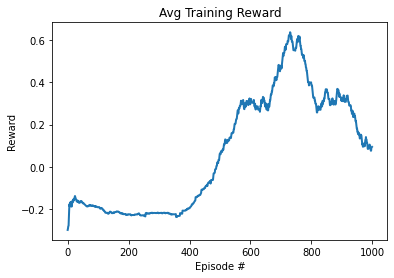

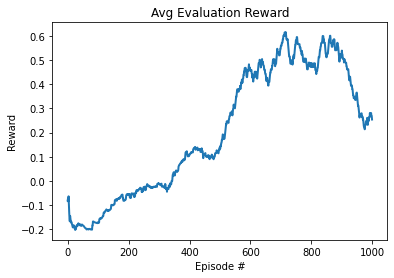

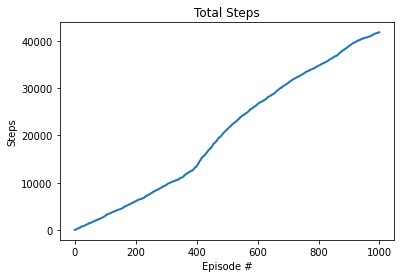

In [20]:
dqn_steps, dqn_rewards, dqn_score = result.T

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot(dqn_rewards, linewidth=2)
plt.ylabel('Reward')
plt.xlabel('Episode #')
ax1.set_title('Avg Training Reward')


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(dqn_score, linewidth=2)
plt.ylabel('Reward')
plt.xlabel('Episode #')
ax2.set_title('Avg Evaluation Reward')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
plt.plot(dqn_steps, linewidth=2)
plt.ylabel('Steps')
plt.xlabel('Episode #')
ax3.set_title('Total Steps')


plt.show()

In [27]:
env = gym.make('frogger-v1')
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
batch_size = 128
epochs = 40
lr = 5e-4
policy_net = DQNAgent(env.observation_space.shape[0], env.action_space.n, batch_size, epochs, lr)
policy_net.load_checkpoint('model.pth')
state = env.reset()
done = False
while not done:
    action = policy_net.greedy_action(state)
    state, reward, done, _ = env.step(action)
env.close()
show_video('./video')

del env

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>


First, let's test the new environment out!

The observation that the agent receives is a history of lidar scans + distance to the goal + direction to the goal.

The action space consists of five actions 0: stand still, 1: move up, 2: move down, 3: move left, 4: move right

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)
